# Memory Cells


In this example, we show to set up a memory cell. In this case, a memory cell consists of one  free layer, and two pinned layer, one on the top and one on the bottom of the free layer which both serve as reference layers and provide different polarisations of the spin current ($x$ and $-y$). 
If we time the current impulses through both of those reference layers we can smartly speed up the switching of the perpendicularly magnetised cell from $m_z$ to $-m_z$ without having to apply an external magnetic field.

In this example we set field-like torque to 0, through `NullDriver`, this of course can be done with `constantDriver(0)` or `ScalarDriver.getConstantDriver(0)` as well. 


The simulation can be more realistic in the `cmtj` through the addition of temperature, non-trivial demagnetisation tensor and `dipole` tensor.



### **References:**

[1] de Orio, R. L. et al. Numerical Analysis of Deterministic Switching of a Perpendicularly Magnetized Spin-Orbit Torque Memory Cell. IEEE Journal of the Electron Devices Society 9, 61–67 (2021).

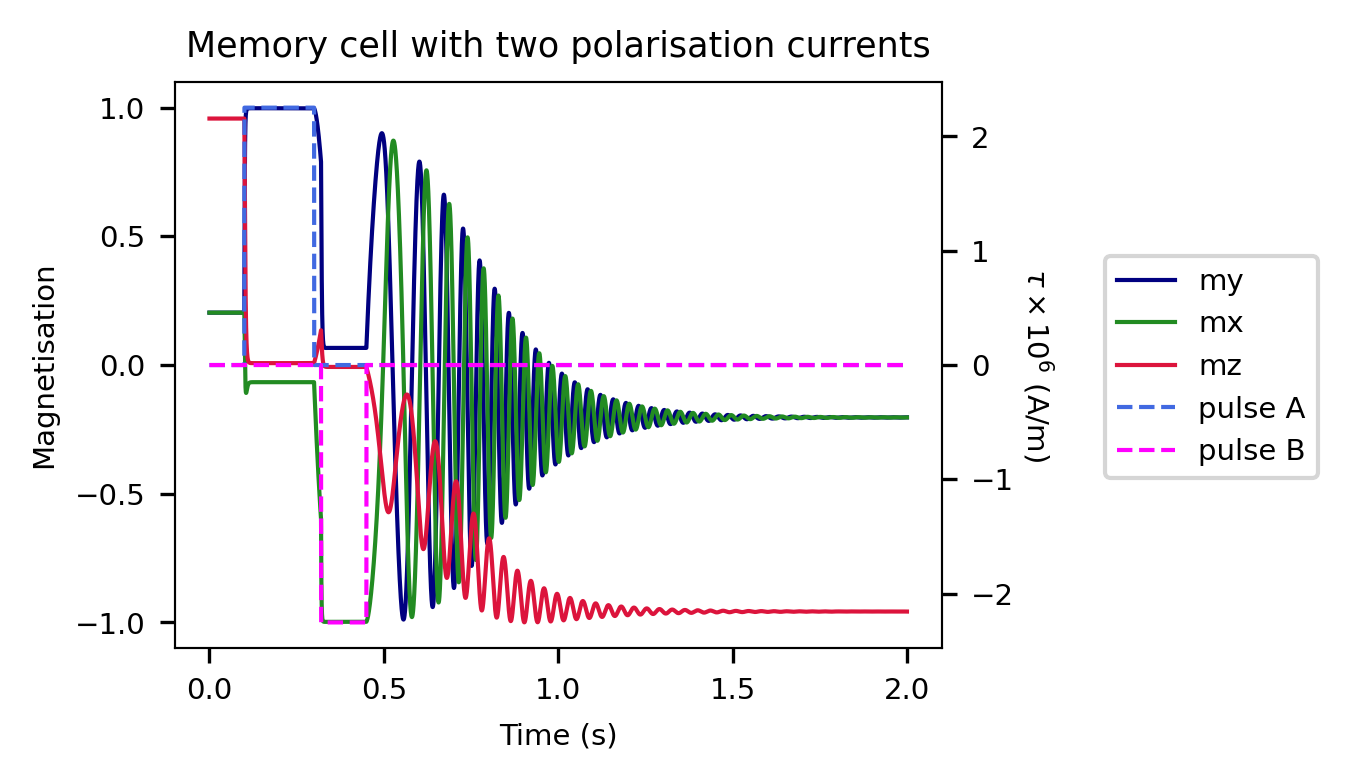

In [39]:
from cmtj import (
    Junction,
    CVector,
    Layer,
    ScalarDriver,
    constantDriver,
    stepDriver,
    NullDriver,
)
from math import pi
from cmtj.utils import TtoAm

demag = [CVector(1e-6, 0, 0), CVector(0, 1e-6, 0), CVector(0, 0, 0.9996)]
alpha = 0.035
surface = 150e-9 * 150e-9 * pi
Kdir = CVector(0.1, 0.1, 1)
Ms = 1.08
d = 1.55e-9
l1 = Layer(
    "free",
    mag=CVector(0.1, 0.1, 0.9),
    anis=Kdir,
    Ms=Ms,
    thickness=d,
    cellSurface=surface,
    demagTensor=demag,
    damping=alpha,
)
K1 = 8.4e5
v1 = CVector(0, 1, 0)
v2 = CVector(1, 0, 0)
l1.setReferenceLayer(v1)
l1.setSecondaryReferenceLayer(v2)
junction = Junction([l1])
junction.setLayerAnisotropyDriver("free", constantDriver(K1))
junction.runSimulation(2e-9, 1e-13, 1e-13)
junction.clearLog()
sh1 = 0.3 / 100
sh2 = 0.3 / 100
sgn = 1
j1 = sgn * 1e6
j2 = -sgn * 1e6


t1start = 0.1e-9
t1stop = 0.3e-9

t2start = 0.32e-9
t2stop = 0.45e-9

t3start = 1.2e-9
t3stop = 1.4e-9

ampl1 = sh1 * j1 / (Ms * TtoAm * d)
ampl2 = sh2 * j2 / (Ms * TtoAm * d)

fl1 = NullDriver()
dl1 = stepDriver(0, ampl1, t1start, t1stop)

"""
just for sport, we define a current impulse 
"""


def custom_step_impulse(time: float) -> float:
    if t2start < time < t2stop:
        return ampl2
    return 0


# Create a driver with this function
driver = ScalarDriver.getCustomDriver(custom_step_impulse)

# fl2 = driver * 0
fl2 = NullDriver()
dl2 = driver


junction.setLayerPrimaryTorqueDrivers(
    "free", fieldLikeTorque=fl1, dampingLikeTorque=dl1
)
junction.setLayerSecondaryTorqueDrivers(
    "free", fieldLikeTorque=fl2, dampingLikeTorque=dl2
)


junction.runSimulation(2e-9, 1e-13, 1e-13)
log = junction.getLog()

tm = np.asarray(log["time"])
driver_values_A = [dl1.getCurrentScalarValue(t)/1e6 for t in tm]
driver_values_B = [dl2.getCurrentScalarValue(t)/1e6 for t in tm]

import matplotlib.pyplot as plt
import numpy as np

# with plt.style.context(["science", "nature"]):
with plt.style.context("nature"):
    # Set figure style with no y-axis offset
    plt.rcParams["axes.formatter.useoffset"] = False
    fig, ax = plt.subplots(dpi=300)
    mz = np.asarray(log["free_mz"])
    my = np.asarray(log["free_my"])
    mx = np.asarray(log["free_mx"])
    ax.plot(tm * 1e9, my, label="my", color="navy")
    ax.plot(tm * 1e9, mx, label="mx", color="forestgreen")
    ax.plot(tm * 1e9, mz, label="mz", color="crimson")

    ax2 = ax.twinx()
    ax2.plot(
        tm * 1e9,
        driver_values_A,
        label="pulse A",
        color="royalblue",
        linestyle="dashed",
    )
    ax2.plot(
        tm * 1e9, driver_values_B, label="pulse B", color="magenta", linestyle="dashed"
    )

    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Magnetisation")
    ax.set_title("Memory cell with two polarisation currents")

    ax2.set_ylabel(r"$\tau \times 10^6$ (A/m)", rotation=270, labelpad=10)
    # Create a legend outside the plot
    fig.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))